### EP3 - Classificação de diagnóstico de Covid-19
>Fernando Gouveia Lima - NUSP \
>Rodrigo de Castro Michelassi - 13672703
>
>Instituto de Matemática e Estatística \
>Universidade de São Paulo
>
>MAC0425 | Inteligência Artificial

### Imports
Primeiro será feito o import das bibliotecas utilizadas. Após isto, será feito a leitura dos dados.

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn as skl
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [68]:
df_pacientes = pd.read_csv('HC_PACIENTES_1.csv', sep='|')
df_exames = pd.read_csv('HC_EXAMES_1.csv', sep='|')

In [69]:
print(df_pacientes.shape)
print(df_exames.shape)

(3751, 7)
(2498650, 9)


In [70]:
df_pacientes.head(7)

,ID_PACIENTE,IC_SEXO,AA_NASCIMENTO,CD_PAIS,CD_UF,CD_MUNICIPIO,CD_CEPREDUZIDO
0,9698838a8fa8a01ffd5ed5c71e8e17a3,F,1962,BR,SP,SAO PAULO,CCCC
1,d9fec23b3820f93a961841d569db8cb5,F,1974,BR,SP,MMMM,CCCC
2,ee507ba3a9959fdf31bca52852fd5715,F,1962,BR,SP,MMMM,CCCC
3,51590e8c53f4e8e332c05d7e6cee35c7,F,1960,BR,SP,SAO PAULO,CCCC
4,13699f0f7714fdaba277c5e360c6869c,M,1967,BR,SP,MMMM,CCCC
5,9bd839fe149857321685b1e1d8a55cbd,F,1948,BR,SP,SAO PAULO,CCCC
6,b723165a04c8e28fe2b4dcff8dc8dab3,F,1963,BR,SP,MMMM,CCCC


In [71]:
df_exames.head(7)

,ID_PACIENTE,ID_aTENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA
0,004056afeb7b5441855846349123f686,0ae989c74676b6b5b8bf1a5f57be45f7,2020-05-17,HOSP,CULTURA AERÓBIA,CULTURA AERÓBIA,Negativa,NaN,Negativa
1,004056afeb7b5441855846349123f686,0ae989c74676b6b5b8bf1a5f57be45f7,2020-05-17,HOSP,URÉIA,URÉIA,10,mg/dL,10 a 50 mg/dL
2,004056afeb7b5441855846349123f686,0ae989c74676b6b5b8bf1a5f57be45f7,2020-05-17,HOSP,URINA TIPO 1,pH :,7.0,NaN,5.0 a 6.0
3,004056afeb7b5441855846349123f686,0ae989c74676b6b5b8bf1a5f57be45f7,2020-05-17,HOSP,URINA TIPO 1,Urobilinogenio :,0.2,mg/dL,0.2 a 1.0 mg/dL
4,004056afeb7b5441855846349123f686,0ae989c74676b6b5b8bf1a5f57be45f7,2020-05-17,HOSP,URINA TIPO 1,Sangue :,Tracos,NaN,Ausente
5,004056afeb7b5441855846349123f686,0ae989c74676b6b5b8bf1a5f57be45f7,2020-05-17,HOSP,URINA TIPO 1,Proteinas :,Inferior a 0.05,g/L,Inferior a 0.05 g/L
6,004056afeb7b5441855846349123f686,0ae989c74676b6b5b8bf1a5f57be45f7,2020-05-17,HOSP,URINA TIPO 1,Pigmento Biliares :,Ausente,NaN,Ausente


### Unindo as Planilhas

Iremos inserir as informações importantes presentes na planilha `df_pacientes` (Idade e o Sexo do paciente) na planilha `df_exames`.

In [72]:
ano_atual = 2025
df_pacientes['AA_NASCIMENTO'] = pd.to_numeric(df_pacientes['AA_NASCIMENTO'], errors='coerce')
df_pacientes['IDADE'] = ano_atual - df_pacientes['AA_NASCIMENTO']

df_pacientes_reduzido = df_pacientes[['ID_PACIENTE', 'IC_SEXO', 'IDADE']]

print(df_pacientes_reduzido.head(7))

df_final = df_exames.merge(df_pacientes_reduzido, on='ID_PACIENTE', how='left')

                        ID_PACIENTE IC_SEXO  IDADE
0  9698838a8fa8a01ffd5ed5c71e8e17a3       F   63.0
1  d9fec23b3820f93a961841d569db8cb5       F   51.0
2  ee507ba3a9959fdf31bca52852fd5715       F   63.0
3  51590e8c53f4e8e332c05d7e6cee35c7       F   65.0
4  13699f0f7714fdaba277c5e360c6869c       M   58.0
5  9bd839fe149857321685b1e1d8a55cbd       F   77.0
6  b723165a04c8e28fe2b4dcff8dc8dab3       F   62.0


Aqueles exames cujo `ID_Paciente` não está na planilha que descreve os pacientes serão removidos (ou seja, exames realizados por um paciente que não possuímos dados). Isto evita manter dados faltantes como o sexo e a idade daquele paciente no exame.

In [73]:
faltando = df_final[df_final['IDADE'].isna()]
print(f"Número de exames com paciente não encontrado: {len(faltando)}")

df_final = df_final.dropna(subset=['IDADE', 'IC_SEXO'])

Número de exames com paciente não encontrado: 26961


In [74]:
print("\n Váriaveis Categóricas:")
df_final.describe(include=[object, 'category'])


 Váriaveis Categóricas:


,ID_PACIENTE,ID_aTENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,IC_SEXO
count,2471689,2471689,2471689,2471689,2471689,2471689,2467030,2209352,2471689,2471689
unique,3083,3095,274,1,433,893,20871,62,632,2
top,b9c687b7739b1eb2472a306df80e90c7,200563bc4454c79b9e9feb0dabaa289d,2020-06-10,HOSP,HEMOGRAMA COMPLETO,POTÁSSIO,0.0,%,,M
freq,10304,10304,28303,2471689,759543,80602,33976,390892,171422,1651767


In [75]:
print("Variáveis Numéricas:")
df_final.describe(include=[float, int])

Variáveis Numéricas:


,IDADE
count,2.471689e+06
mean,6.451947e+01
std,1.480878e+01
min,2.200000e+01
25%,5.500000e+01
50%,6.700000e+01
75%,7.500000e+01
max,9.400000e+01


### Excluindo Atendimentos sem relação com a COVID

Agora realizaremos a remoção de pacientes não realizaram nenhum exame para a COVID-19.

In [76]:
covid_mask = df_final['DE_EXAME'].str.contains('covid', case=False, na=False)
print(f"Total de paciente que realizaram exames para a COVID: {df_final[covid_mask]['ID_PACIENTE'].nunique()}")

Total de paciente que realizaram exames para a COVID: 756


In [77]:
pacientes_com_covid = df_final[covid_mask]['ID_PACIENTE'].unique()
df_final = df_final[df_final['ID_PACIENTE'].isin(pacientes_com_covid)].copy()

df_final.shape

(711712, 11)

Após, remover estes pacientes percebemos que o número de exames caiu consideravelmente, porém ainda é bem alto e devemos investigar isso. Iremos alterar o dataframe para que ele possua um único paciente por linha e as colunas serão representativas de alguns de seus exames.

### Análise de Exames com relação a COVID

Primeiramente, voltaremos a atenção para como estão distribuídos os dados de exames relacionados com a COVID.

In [78]:
df_only_covid = df_final[covid_mask]
df_only_covid.head()

/var/folders/ty/w484s12s44x17p2vph_lydvm0000gn/T/ipykernel_19324/914241897.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_only_covid = df_final[covid_mask]


,ID_PACIENTE,ID_aTENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,IC_SEXO,IDADE
154,004056afeb7b5441855846349123f686,0ae989c74676b6b5b8bf1a5f57be45f7,2020-05-22,HOSP,Teste Rápido para SARS-CoV-2- Pesquisa de anti...,Teste Rápido para SARS-CoV-2- Pesquisa de anticor,Não Reagente,NaN,Não Reagente,F,25.0
1312,027d36400fab635475df302c0c658e28,33cd306a908569007cd37a2a18e996f4,2020-05-27,HOSP,Teste Rápido para SARS-CoV-2- Pesquisa de anti...,Teste Rápido para SARS-CoV-2- Pesquisa de anticor,Reagente,NaN,Não Reagente,F,55.0
1741,0287d10a62856235107a2b02beb8b606,ec74d150149d75f27230230d11c04be0,2020-08-14,HOSP,COVID-19 - PESQUISA DE ANTICORPOS IgG,Índice:,6.9,NaN,,M,63.0
1742,0287d10a62856235107a2b02beb8b606,ec74d150149d75f27230230d11c04be0,2020-08-14,HOSP,COVID-19 - PESQUISA DE ANTICORPOS IgG,COVID-19 IgG,Reagente,NaN,Inconclusivo: Índice >= 0.8 e < 1.1;Não reage...,M,63.0
9926,06a421bbe84023a5ee9c276e2b763811,472f87a595405b994e5d017dbfdbd761,2020-06-03,HOSP,COVID-19 - PESQUISA DE ANTICORPOS IgG,Índice:,0.2,NaN,,M,84.0


In [79]:
print(df_only_covid['DE_EXAME'].value_counts())
print(df_only_covid['DE_ANALITO'].value_counts())
print(df_only_covid['DE_RESULTADO'].value_counts())

DE_EXAME
COVID-19 - PESQUISA DE ANTICORPOS IgG                                                       1496
Teste Rápido para SARS-CoV-2- Pesquisa de anticorpos IgG e IgM (Sorologia para COVID-19)     283
COVID TESTE LÍQUOR                                                                            11
TESTE RÁPIDO PARA COVID-19 DE PONTA DE DEDO                                                    1
Name: count, dtype: int64
DE_ANALITO
Índice:                                              748
COVID-19 IgG                                         748
Teste Rápido para SARS-CoV-2- Pesquisa de anticor    283
COVID TESTE LÍQUOR                                    11
TESTE RÁPIDO PARA COVID-19 DE PONTA DE DEDO            1
Name: count, dtype: int64
DE_RESULTADO
Reagente        665
Não reagente    253
0.2             111
Não Reagente    103
0.3              41
               ... 
6.5               1
2.3               1
8.8               1
16.8              1
16.1              1
Name: count, Length: 1

Após a análise dessas informações, percebemos que há 748 exames **COVID-19 - PESQUISA DE ANTICORPOS IgG** que resultam em 2 formas de analito. Uma indica o índice de anticorpos IgG e a outra indica se o paciente é `Reagente` ou `Não Reagente`.

Portanto, iremos remover as linhas que indicam se aquele paciente é reagente ou não. Pois, elas representam a classificação que estamos buscando e não serão úteis no treinamento.

Os exames **Teste Rápido para SARS-CoV-2- Pesquisa de anticor** serão mantidos e os resultados afirmando se o paciente é `Reagente` ou `Não reagente` serão substituidos por valores baseados nas referências fornecidas. Isto será realizado para não haver uma pequena quantidade de dados.

Já os exames **COVID TESTE LÍQUOR** e **TESTE RÁPIDO PARA COVID-19 DE PONTA DE DEDO** serão removidos devido a sua baixa quantidade de dados, o que pode gerar ruídos para o modelo.

In [80]:
exame_to_remove = ['COVID TESTE LÍQUOR', 'TESTE RÁPIDO PARA COVID-19 DE PONTA DE DEDO', 'COVID-19 IgG', 'Teste Rápido para SARS-CoV-2- Pesquisa de anticor']
df_only_covid = df_only_covid[~df_only_covid['DE_ANALITO'].isin(exame_to_remove)].copy()

print("Após a remoção:")
df_only_covid.head(4)

Após a remoção:


,ID_PACIENTE,ID_aTENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,IC_SEXO,IDADE
1741,0287d10a62856235107a2b02beb8b606,ec74d150149d75f27230230d11c04be0,2020-08-14,HOSP,COVID-19 - PESQUISA DE ANTICORPOS IgG,Índice:,6.9,NaN,,M,63.0
9926,06a421bbe84023a5ee9c276e2b763811,472f87a595405b994e5d017dbfdbd761,2020-06-03,HOSP,COVID-19 - PESQUISA DE ANTICORPOS IgG,Índice:,0.2,NaN,,M,84.0
10022,06a421bbe84023a5ee9c276e2b763811,472f87a595405b994e5d017dbfdbd761,2020-06-07,HOSP,COVID-19 - PESQUISA DE ANTICORPOS IgG,Índice:,0.7,NaN,,M,84.0
12151,06c26c3f7126540b50ecc2e47d1367d0,8b12ccb043fe02258269a8d56d9e9b7f,2020-06-04,HOSP,COVID-19 - PESQUISA DE ANTICORPOS IgG,Índice:,0.5,NaN,,F,36.0


Criando o vetor booleano para o treinamento

In [81]:
def covid_positiva(row):
    analito = str(row['DE_ANALITO']).lower()
    resultado = str(row['DE_RESULTADO']).strip().lower()

    if "teste rápido" in analito and "anticor" in analito:
        if resultado == "reagente":
            return 1
        elif resultado == "não reagente":
            return 0

    if "índice" in analito:
        try:
            valor = float(resultado.replace(",", "."))
            return int(valor >= 0.95)
        except:
            return np.nan

    return np.nan

covid_boolean_vector = df_only_covid.apply(covid_positiva, axis=1)
covid_boolean_vector.head(7)

1741     1
9926     0
10022    0
12151    0
13675    1
17410    1
17458    1
dtype: int64

Agora serão removidas as colunas desnecessárias para a classificação do modelo, ou seja, colunas como `ID_ATENDIMENTO`, `DE_Origem`, `DE_EXAM`, etc. que são colunas com variáveis categóricas ou sem relação com a doença.

Todavia, iremos adicionar uma nova coluna chamada `COVID-19 IgG` que conterá os indíces de valores dos anti-corpos. Para os exames **Teste Rápido para SARS-CoV-2** serão utilizados 2 valores com base nos índices de referência fornecidos.

In [82]:
def extrair_igg(row):
    resultado = str(row['DE_RESULTADO']).strip().lower()
    try:
        return float(resultado.replace(",", "."))
    except:
        if resultado == "não reagente":
            return 0.3
        elif resultado == "reagente":
            return 2.0
        else:
            return None

df_only_covid['COVID-19 IgG'] = df_only_covid.apply(extrair_igg, axis=1)

columns_to_drop = [
    'ID_aTENDIMENTO', 'DT_COLETA', 'DE_ORIGEM', 'DE_EXAME',
    'DE_ANALITO', 'DE_RESULTADO', 'CD_UNIDADE', 'DE_VALOR_REFERENCIA'
]
df_only_covid = df_only_covid.drop(columns=columns_to_drop)
df_only_covid.head(4)

,ID_PACIENTE,IC_SEXO,IDADE,COVID-19 IgG
1741,0287d10a62856235107a2b02beb8b606,M,63.0,6.9
9926,06a421bbe84023a5ee9c276e2b763811,M,84.0,0.2
10022,06a421bbe84023a5ee9c276e2b763811,M,84.0,0.7
12151,06c26c3f7126540b50ecc2e47d1367d0,F,36.0,0.5


### Transformando Exames em Coluna

Após pré-processar os dados dos pacientes que realizaram exame de COVID, iremos adicionar alguns outros exames realizados como colunas ao invés de linha. Isto será feito para buscar uma melhor performace na hora de classificação, pois alguns dos outros exames possam ser importantes para auxiliarem o modelo a diferenciar se a pessoa está ou não infectada com o vírus.

Para isso, alguns analitos (da coluna `DE_ANALITO`) que possuem diversas informações de outros exames serão transformados em colunas nessa nova planilha. E o conteúdo de cada campo será preenchido com os valores da coluna `DE_RESULTADO`.

Portanto, precisamos fazer uma análise detalhada sobre os analitos para verificar quais devem ser transformados em colunas e quais não.

In [83]:
# Remove as linhas de exames da covid já pré-processadas.
df_final = df_final[~df_final['DE_EXAME'].str.contains('covid', case=False, na=False)].copy()

In [84]:
print("\nDescrição da coluna DE_ANALITO:")
print(df_final['DE_ANALITO'].describe())


Descrição da coluna DE_ANALITO:
count       709921
unique         698
top       POTÁSSIO
freq         22895
Name: DE_ANALITO, dtype: object


Percebe-se que o número de analitos é bastante alto, não necessariamente queremos incluir todos na planilha.

Logo, vamos primeiramente visualizar quais são os analitos númericos mais frequentes e se algum deles pode possuir relação com a COVID. Eles precisam ser necessáriamente númericos, para facilitar a classificação do modelo sem a necessidade de realizar one-hot-encoding para um número expressivo de resultados diferentes para cada analito.

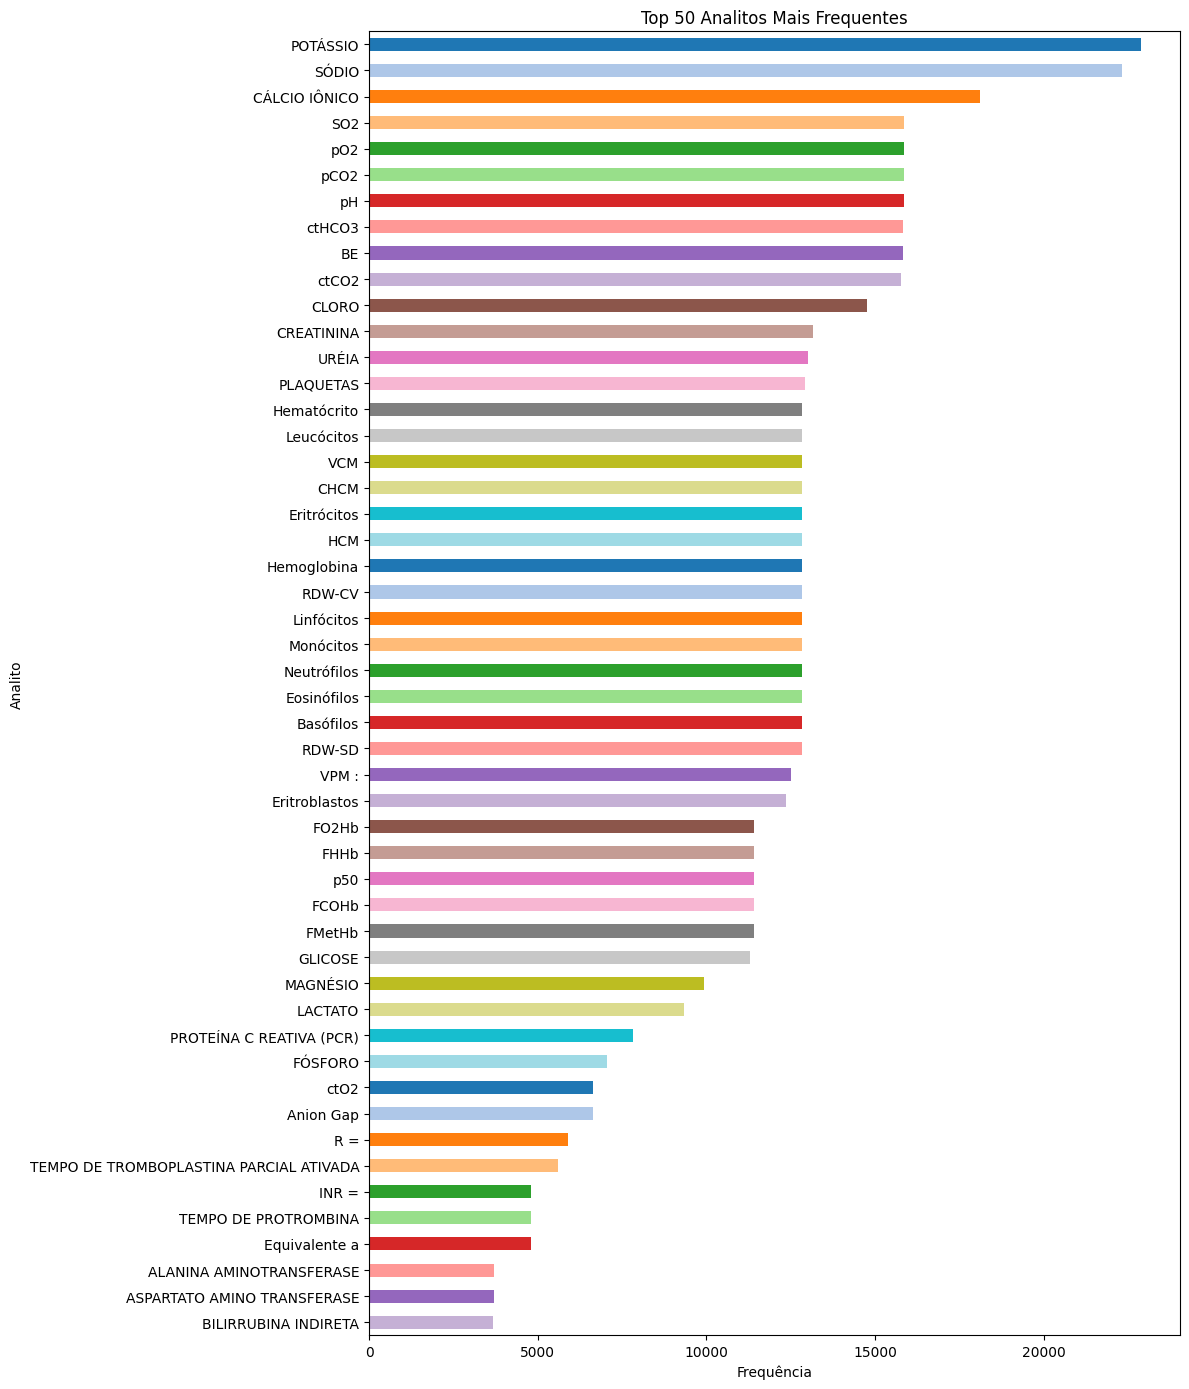

In [85]:
numeric_results = pd.to_numeric(df_final['DE_RESULTADO'], errors='coerce').notna()
df_numeric_analitos = df_final[numeric_results]

top_50_analitos = df_numeric_analitos['DE_ANALITO'].value_counts().head(50)

# Plot
plt.figure(figsize=(12, 14))

top_50_analitos.plot(kind='barh', color=plt.cm.tab20.colors)

plt.title('Top 50 Analitos Mais Frequentes')
plt.xlabel('Frequência')
plt.ylabel('Analito')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

Após uma análise preliminar dos dados disponíveis, foi possível identificar que os 30 primeiros analitos apresentam uma correlação mais relevante com os casos de COVID-19. Essa observação foi feita com base em critérios de associação estatística e/ou evidência prévia na literatura.

Dentre os analitos selecionados, destacam-se compostos como o dióxido de enxofre (SO₂), que pode atuar como marcador da qualidade do ar e está associado a efeitos respiratórios.

In [86]:
top_30_analitos = df_final['DE_ANALITO'].value_counts().head(30).index.tolist()
df_top_analitos = df_final[df_final['DE_ANALITO'].isin(top_30_analitos)]

df_pivot = df_top_analitos.pivot_table(
    index=['ID_PACIENTE', 'IC_SEXO', 'IDADE'],
    columns='DE_ANALITO',
    values='DE_RESULTADO',
    aggfunc='first'
).reset_index()

df_pivot = df_pivot.dropna(axis=1, how='all')
df_covid_final = pd.merge(df_only_covid, df_pivot, on=['ID_PACIENTE', 'IC_SEXO', 'IDADE'], how='left')
df_covid_final.head(7)

,ID_PACIENTE,IC_SEXO,IDADE,COVID-19 IgG,BE,Basófilos,CHCM,CLORO,CREATININA,CÁLCIO IÔNICO,...,SO2,SÓDIO,URÉIA,VCM,VPM :,ctCO2,ctHCO3,pCO2,pH,pO2
0,0287d10a62856235107a2b02beb8b606,M,63.0,6.9,8.2,0.02,31.3,103,0.90,4.09,...,82.9,145,27,105.1,10.2,41.0,38.7,75.4,7.330,54.4
1,06a421bbe84023a5ee9c276e2b763811,M,84.0,0.2,0.6,0.00,34.0,95,1.16,4.60,...,97.5,147,41,83.2,9.7,26.1,24.9,41.0,7.401,93.1
2,06a421bbe84023a5ee9c276e2b763811,M,84.0,0.7,0.6,0.00,34.0,95,1.16,4.60,...,97.5,147,41,83.2,9.7,26.1,24.9,41.0,7.401,93.1
3,06c26c3f7126540b50ecc2e47d1367d0,F,36.0,0.5,NaN,0.01,34.8,106,0.60,NaN,...,NaN,137,9,80.2,11.4,NaN,NaN,NaN,NaN,NaN
4,08eaf62182807157c0e64cfb556512f6,F,28.0,1.5,-1.3,0.04,35.6,110,0.57,5.45,...,85.3,141,14,81.3,11.5,23.1,22.1,34.2,7.426,50.9
5,0ad3fc4a27d56332f4b48e0483f248c8,M,90.0,6.2,4.1,0.0,32.6,98,1.03,4.37,...,92.0,138,42,83.8,8.7,29.5,28.2,42.3,7.439,66.8
6,0ad3fc4a27d56332f4b48e0483f248c8,M,90.0,11.6,4.1,0.0,32.6,98,1.03,4.37,...,92.0,138,42,83.8,8.7,29.5,28.2,42.3,7.439,66.8


In [87]:
df_covid_final.shape

(748, 34)

In [88]:
nan_counts = df_covid_final.isna().sum().sort_values(ascending=False)
print(nan_counts)

CLORO                        72
ctCO2                        68
pO2                          63
SO2                          63
pH                           63
pCO2                         63
BE                           63
ctHCO3                       63
CÁLCIO IÔNICO                54
SÓDIO                         4
Observação Série Vermelha     2
VCM                           2
URÉIA                         2
VPM :                         2
RDW-SD                        2
RDW-CV                        2
POTÁSSIO                      2
PLAQUETAS                     2
Monócitos                     2
Neutrófilos                   2
Linfócitos                    2
Leucócitos                    2
Hemoglobina                   2
Hematócrito                   2
HCM                           2
Eritrócitos                   2
Eosinófilos                   2
CREATININA                    2
CHCM                          2
Basófilos                     2
IC_SEXO                       0
COVID-19

Constatou-se que algumas colunas apresentavam um número excessivo de valores ausentes (NaN), o que comprometeria a qualidade das análises estatísticas e modelagens subsequentes. Diante disso, optou-se por remover essas colunas do conjunto de dados.

Para as demais variáveis que apresentaram valores ausentes em menor proporção, foi adotada a técnica de imputação utilizando a média dos respectivos atributos

Além disso será removida a coluna `ID_PACIENTE` e a coluna `IC_SEXO` será transformada em booleana, indicando 1 para Masculino e 0 para Feminino.

In [89]:
columns_to_drop = ['ctCO2', 'CLORO', 'pCO2', 'BE', 'ctHCO3', 'CÁLCIO IÔNICO', 'ID_PACIENTE', 'Observação Série Vermelha', 'COVID-19 IgG']
df_covid_final = df_covid_final.drop(columns=columns_to_drop, errors='ignore')

df_covid_final = df_covid_final.apply(pd.to_numeric, errors='ignore')
df_covid_final['IC_SEXO'] = df_covid_final['IC_SEXO'].map({'M': 1, 'F': 0})

for col in df_covid_final.columns:
    if df_covid_final[col].dtype == 'object':
        df_covid_final[col] = pd.to_numeric(df_covid_final[col], errors='coerce')

colums = df_covid_final.select_dtypes(include='number').columns
df_covid_final[colums] = df_covid_final[colums].fillna(df_covid_final[colums].mean())

df_covid_final.shape

/var/folders/ty/w484s12s44x17p2vph_lydvm0000gn/T/ipykernel_19324/3742886994.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_covid_final = df_covid_final.apply(pd.to_numeric, errors='ignore')


(748, 25)

In [90]:
df_covid_final.head(7)

,IC_SEXO,IDADE,Basófilos,CHCM,CREATININA,Eosinófilos,Eritrócitos,HCM,Hematócrito,Hemoglobina,...,POTÁSSIO,RDW-CV,RDW-SD,SO2,SÓDIO,URÉIA,VCM,VPM :,pH,pO2
0,1,63.0,0.02,31.3,0.90,0.07,5.53,32.9,58.1,18.2,...,4.9,13.7,53.6,82.900000,145.0,27.0,105.1,10.2,7.330000,54.400000
1,1,84.0,0.00,34.0,1.16,0.06,4.17,28.3,34.7,11.8,...,3.8,13.7,41.5,97.500000,147.0,41.0,83.2,9.7,7.401000,93.100000
2,1,84.0,0.00,34.0,1.16,0.06,4.17,28.3,34.7,11.8,...,3.8,13.7,41.5,97.500000,147.0,41.0,83.2,9.7,7.401000,93.100000
3,0,36.0,0.01,34.8,0.60,0.01,4.59,27.9,36.8,12.8,...,3.3,14.4,41.9,80.368759,137.0,9.0,80.2,11.4,7.375791,62.469343
4,0,28.0,0.04,35.6,0.57,0.12,4.39,28.9,35.7,12.7,...,3.3,13.8,40.3,85.300000,141.0,14.0,81.3,11.5,7.426000,50.900000
5,1,90.0,0.00,32.6,1.03,0.70,3.40,27.4,28.5,9.3,...,4.2,15.0,45.9,92.000000,138.0,42.0,83.8,8.7,7.439000,66.800000
6,1,90.0,0.00,32.6,1.03,0.70,3.40,27.4,28.5,9.3,...,4.2,15.0,45.9,92.000000,138.0,42.0,83.8,8.7,7.439000,66.800000


Com isso concluimos a parte de pré-processamento de dados e iniciaremos o processo de criação da arquitetura da rede!

### Preparação do Dataset

Iremos dividir o dataset entre dados de treino e teste, e criar os Dataloaders do PyTorch para treinar o modelo. Os dados devem estar formatados como tensores, para serem usados no PyTorch.

In [91]:
print(df_covid_final.shape)
print(covid_boolean_vector.shape)

(748, 25)
(748,)


In [92]:
X = df_covid_final
y = covid_boolean_vector.to_frame()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
X_train = torch.tensor(X_train.values, dtype=torch.float32) 
y_train = torch.tensor(y_train.values, dtype=torch.float32)

X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

Definir um dataset para os tensores representativos dos dados

In [94]:
from torch.utils.data import Dataset

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TabularDataset(X_train, y_train)
test_dataset = TabularDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Definição da Rede

In [95]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(input_dim, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)

        return x

### Treinamento do modelo

In [96]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    running_loss = 0.
    total = 0.
    correct = 0

    model.train()
    for data in train_loader:
        x, y = data
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.numel()
    
    acc = correct / total
    loss = running_loss / len(train_loader)

    return acc, loss

def train_model(train_loader, epochs, lr, input_dim):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using {device}")

    model = Net(input_dim).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)

    acc_hist = []
    loss_hist = []

    for epoch in range(epochs):
        acc, loss = train_epoch(model, train_loader, optimizer, criterion, device)
        acc_hist.append(acc)
        loss_hist.append(loss)

        print(f"Epoch {epoch}, loss = {loss}, accuracy = {acc}")
    
    return acc_hist, loss_hist, model

In [97]:
acc_hist, loss_hist, model = train_model(train_loader, epochs=100, lr=0.0001, input_dim=X_train.shape[1])

Using mps
Epoch 0, loss = 0.8811333838262057, accuracy = 0.5852842809364549
Epoch 1, loss = 0.6592130692381608, accuracy = 0.6471571906354515
Epoch 2, loss = 0.6299430508362619, accuracy = 0.6538461538461539
Epoch 3, loss = 0.6284611946658084, accuracy = 0.6521739130434783
Epoch 4, loss = 0.716572388222343, accuracy = 0.6103678929765887
Epoch 5, loss = 0.6638040589658838, accuracy = 0.6521739130434783
Epoch 6, loss = 0.6297601775119179, accuracy = 0.6387959866220736
Epoch 7, loss = 0.6046073421051628, accuracy = 0.6806020066889632
Epoch 8, loss = 0.6297335797234586, accuracy = 0.6521739130434783
Epoch 9, loss = 0.5767730913664165, accuracy = 0.6923076923076923
Epoch 10, loss = 0.5807965601745405, accuracy = 0.6872909698996655
Epoch 11, loss = 0.613367951229999, accuracy = 0.677257525083612
Epoch 12, loss = 0.5507706529215762, accuracy = 0.7207357859531772
Epoch 13, loss = 0.5629738867282867, accuracy = 0.7123745819397993
Epoch 14, loss = 0.579985532321428, accuracy = 0.697324414715719


### Testando o modelo

Agora que realizamos o treinamento, vimos um possível sinal de overfitting, dado que a acurácia atingiu valores extremamente altos. Para termos uma noção real da performance do nosso modelo, precisamos realizar teste, visto que não separamos dataset de validação.

Além disso, estaremos avaliando a performance do modelo em outras métricas, como Precision, Recall e f1-Score, além da Acurácia e Loss.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

def display_metrics(avg_loss, y_true, y_pred, y_pred_prob):
	target_names = ['Adequate', 'Inadequate']

	print(f"\nModel metrics results:\n")

	print(f"Loss: {avg_loss:.4f}")
	print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
	print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
	print(f"Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}")
	print(f"F1-Score: {f1_score(y_true, y_pred, average='weighted'):.4f}")

	print('Confusion Matrix')
	cm = confusion_matrix(y_true, y_pred)
	print(cm)

	print('Classification Report')
	print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

	return cm

def evaluate_model(model, test_loader, loss_fn, device):
	model.eval()

	running_loss = 0.0
	y_true = []
	y_pred = []
	y_pred_prob = []

	with torch.no_grad():
		for data in test_loader:
			X, y = data
			X, y = X.to(device), y.to(device)

			logits = model(X)

			loss = loss_fn(logits, y)
			running_loss += loss.item()

			probs = torch.sigmoid(logits)
			preds = (probs > 0.5).float()

			y_true.extend(y.cpu().numpy())
			y_pred.extend(preds.cpu().numpy())
			y_pred_prob.extend(probs.cpu().numpy())

	avg_loss = running_loss / len(test_loader)
	y_true = np.array(y_true)
	y_pred = np.array(y_pred)
	y_pred_prob = np.array(y_pred_prob)

	return avg_loss, y_true, y_pred, y_pred_prob

def test_model(test_loader, model):
	device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
	print(f"Using {device}")

	model.to(device)
	criterion = nn.BCEWithLogitsLoss()

	avg_loss, y_true, y_pred, y_pred_prob = evaluate_model(model, test_loader, criterion, device)
	cm = display_metrics(avg_loss, y_true, y_pred, y_pred_prob)

	return y_true, y_pred, y_pred_prob, cm

In [99]:
y_true, y_pred, y_pred_prob, cm = test_model(test_loader=test_loader, model=model)

Using mps

Model metrics results:

Loss: 0.7865
Acurácia: 0.6733
Precision: 0.6795
Recall: 0.6733
F1-Score: 0.6289
Confusion Matrix
[[16 42]
 [ 7 85]]
Classification Report
              precision    recall  f1-score   support

    Adequate       0.70      0.28      0.40        58
  Inadequate       0.67      0.92      0.78        92

    accuracy                           0.67       150
   macro avg       0.68      0.60      0.59       150
weighted avg       0.68      0.67      0.63       150



### Gráficos para análise de performance do modelo

Para melhor visualizar os resultados obtidos, iremos plotar alguns gráficos. 

> **Matriz de confusão:** mostra a resposta dada pelo modelo, em comparação com a resposta esperada, para analisar os verdadeiros positivos, falso positivos, entre outros.
>
> **Loss Evolution:** mostra a evolução da Loss, conforme as épocas de treinamento. Importante para ver se o modelo está convergindo.
>
> **Accuracy Evolution:** mostra a evolução da Acurácia, conforme as épocas de treinamento. Também útil para avaliar a evolução do desempenho do modelo conforme o treinamento.

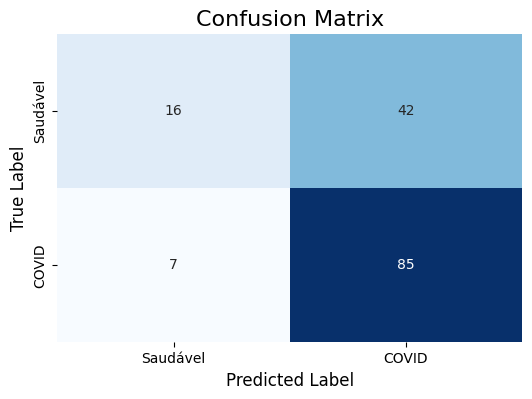

In [106]:
import matplotlib.pyplot as plt

def plotar_matriz_confusao(cm, classes):
    plt.figure(figsize=(6, 4))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes, cbar=False)
    
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    
    plt.show()

class_names = ['Saudável', 'COVID']

plotar_matriz_confusao(cm, class_names)

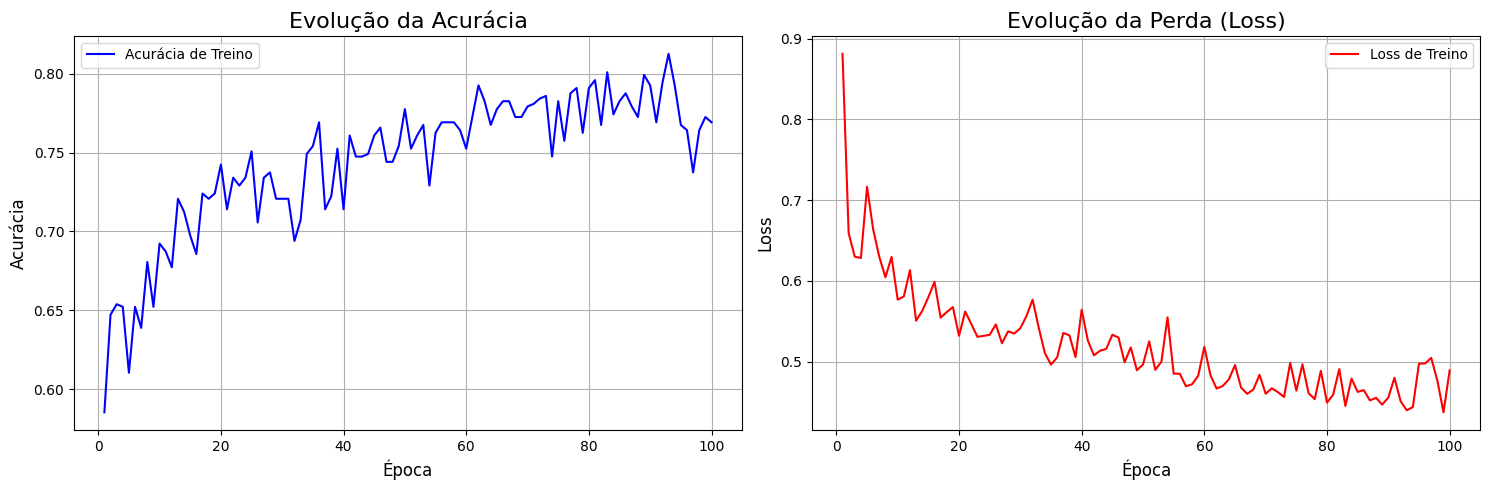

In [105]:
def plotar_curvas_de_treinamento(acc_hist, loss_hist):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs_range = range(1, len(acc_hist) + 1)

    # --- Gráfico da Acurácia ---
    ax1.plot(epochs_range, acc_hist, '-', color='b', label='Acurácia de Treino')
    ax1.set_title('Evolução da Acurácia', fontsize=16)
    ax1.set_xlabel('Época', fontsize=12)
    ax1.set_ylabel('Acurácia', fontsize=12)
    ax1.grid(True)
    ax1.legend()

    # --- Gráfico da Perda (Loss) ---
    ax2.plot(epochs_range, loss_hist, '-', color='r', label='Loss de Treino')
    ax2.set_title('Evolução da Perda (Loss)', fontsize=16)
    ax2.set_xlabel('Época', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plotar_curvas_de_treinamento(acc_hist, loss_hist)